# Women in STEM 
   **Explore gender gap in STEM, predicting salary and job fields**

## Abstract

What is the gender unemployment discrepancy in STEM? How about the gender pay gap? Does it get better over the years? What job fields are less likely to discriminate against women? As a woman working in STEM field, I am intrinsically intersted in answering these question. From Sheryl Sandberg's book Lean In I learned that women earned just 77 cents for every dollar men made. Is this true for the STEM jobs?

In this project, the leading STEM workforce survey data published by HigherEd IPumps will be explored. I will use visualization and statistical analytics to find answers. I will then apply machine learning models to predict salary level, work fields for job seekers. Using random forest classifier, the accuracy score for salary level prediciton is 0.82 even though some vital information is missing in the survey data. The accuracy score goes as high as 0.90 for some principal job fields. 

Presentation slides [HERE](https://www.google.com).


# Table of Contents

1. [Introduction](#intro)  
    1.1 Problem  
    1.2 Target readers  
    1.3 Data Source  
2. [Import Modules](#import)
3. [Data Wrangling](#wrangle)
4. [Exploratory Data Analysis ](#eda)  
5. [Statistical Analysis](#stats)  
6. [Machine Learning](#ml)  
    6.1 [Feature Selection](#dpsp)  
    6.2 [Predicting Salary Level](#psl)  
    6.3 [Predicting job field](#ppjf)  
7. [Summary](#summary)
 

<a id='intro'></a>
## Introduction

### Problem: 
STEM, which stands for science, technology, engineering and math produces many job opportunities in US. However, it is reported by U.S. Department of Commerce that women comprise 48 percent of the U.S. workforce but just 24 percent of STEM workers. This is means half as many women are working in STEM jobs. Why is this happening? What people majored in during higher education plays a very importatant role in the types of work force they enter after they graduate. Does this mean less female students are majored in STEM topics as well? There might be many factors contributing to the unbalanced situation, including personal interst, cultures, and plainly not seeing of the job opportunity after graduation. 

What is the percentage of women in STEM jobs? What is the average salary for female STEM students? What is gender pay gap like? How about race pay gap? What is the top/bottom paid jobs for women STEM Majors? How do the answers to the above questions change for graduate students as opposed to undergraduate? 

I would like to try to predict if a person is going to make a high level salary given other information of the data. It would also help if we can predict the principal job field given the pre-employment data. This could help to make a career suggestion for a particular female STEM student.


### Target readers:
* Career building website such as Linkedin.com and CareerBuilder.com could use this data analysis and model to send customized career suggestions to their users.   
* I am hoping this project would give female STEM majors some insight about what they can expect, how to prepare themselves and where to start as they get ready to go into the work force. 
* In addition, female high school students interested in STEM might use this information to help them choose a major that could possibly benefit them careerwise.

### Data Source:
The survey data on scientist and engineers is acquired from the IPUMPS-Higher ED  (https://highered.ipums.org/highered-action/variables/group). 

The variables I am choosing contains information about: gender, age, race, field of major for highest degree, labor force status, full/part-time status, Principal job related to highest degree, job code for principal job, , salaries and etc. I will also choose these data between the year 2003 and 2013 to compare how things have changed over the years. 

<a id='import'></a>
## Import Modules

In [1]:
# import important stuff
import numpy as np
import pandas as pd

In [2]:
# import visulization modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline

In [3]:
# import stats modules
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency

In [4]:
# import sklearn modules
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

<a id='wrangle'></a>
## Data Wrangling

In [5]:
# import the data from csv file with a series of NAN values 
df1 = pd.read_csv('./../data/highered_00004.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df1 = df1.drop(['REFID'], axis=1)
df2 = pd.read_csv('./../data/highered_00007.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )
df3 = pd.read_csv('./../data/highered_00008.csv', dtype={'REFID': str},na_values=[96, 99, 98, 9996, 9998 ,
    9999, 999996, 999998, 999999, 9999998, 9999999] )

# merge the data frames containing different features
dfm = df1.merge(df2,  on=['PERSONID', 'YEAR', 'WEIGHT', 'SAMPLE', 'SURID'])
df = dfm.merge(df3, on=['PERSONID', 'YEAR', 'SURID'])

Next I will take a portion of the data of employed only for salary and job field prediction. The labor force status was chosen in the next cell and some irrelevent or heavily missing data columns were removed.

In [6]:
#drop columns with irrelevant or many missing data
df_employed = df[df['LFSTAT']==1]
df_employed_small = df_employed.drop(['CTZUS', 'WEIGHT', 'WRKG', 'NRREA','FNVS', 'CHTOT', 'CPI2009C', 'PERSONID', 'LFSTAT','BA03Y5', 'LOOKWK'], axis=1)
df_employed_l = df_employed_small.dropna()

**For EDA purpose only, I will use string catagorical columns that actually contain information to replace numerical data for simple understanding.**

In [7]:
min_map = {0: 'Not minority', 1: 'Minority'}
df['MNTRS'] = df['MINRTY'].map(min_map)

gen_map = {1: 'Female', 2: 'Male'}
df['GENDERS'] = df['GENDER'].map(gen_map)

major_map = {1: 'Computer/Maths Sciences', 2: 'Bio., Agr. and Env. sciences', 3: 'Physical Sciences', 4: 'Social Sciences', 5: 'Engineering', 6: 'Science and engineering-related fields', 7: 'Non-science and engineering fields' }
df['MajorS'] = df['NDGMEMG'].map(major_map)

job_map = {1: 'Computer/Maths Sciences', 2: 'Bio., Agr. and Env. sciences', 3: 'Physical Sciences', 4: 'Social Sciences', 5: 'Engineering', 6: 'Science and engineering-related fields', 7: 'Non-science and engineering fields' }
df['JobS'] = df['NOCPRMG'].map(job_map)

race_map = {1: 'Asian', 2: 'White', 3: 'Other Minorities', 4: 'Other'}
df['RACES'] = df['RACETH'].map(race_map)

LF_map = {1: 'Employed', 2: 'Unemployed'}
df['LFSTATS'] = df['LFSTAT'].map(LF_map)
df['LFSTATS'] = df['LFSTATS'].replace(3,np.NaN)

birth_map = {0: 'Not in the US', 1: 'Born in the US'}
df['BUSS'] = df['BTHUS'].map(birth_map)

JS_map = {1: 'Satisfied', 2: 'Satisfied', 3: 'Dissatisfied', 4: 'Dissatisfied'}
df['JobSatis'] = df['JOBSATIS'].map(JS_map)
df_gender_satisfy = df.groupby('GENDERS')['JobSatis'].value_counts(normalize=True).unstack().reset_index()

JR_map = {1: 'Related', 2: 'Related', 3: 'Not Related'}
df['JobR'] = df['OCEDRLP'].map(JR_map)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478747 entries, 0 to 478746
Data columns (total 58 columns):
PERSONID    478747 non-null int64
YEAR        478747 non-null int64
WEIGHT      478737 non-null float64
SAMPLE      478747 non-null int64
SURID       478747 non-null int64
AGE         478747 non-null int64
BIRYR       478747 non-null int64
GENDER      478747 non-null int64
MINRTY      478747 non-null int64
RACETH      478747 non-null int64
BTHUS       478747 non-null int64
CTZUSIN     478747 non-null int64
CTZUS       438777 non-null float64
FNVS        20573 non-null float64
CHTOT       219740 non-null float64
BA03Y5      465491 non-null float64
NBAMED      463945 non-null float64
NBAMEMG     465494 non-null float64
DGRDG       478747 non-null int64
HD03Y5      478747 non-null int64
NDGMED      478747 non-null int64
NDGMEMG     478747 non-null int64
LFSTAT      478747 non-null int64
WRKG        478747 non-null int64
HRSWKGR     407478 non-null float64
WKSWKGR     407478 non-n

**Drop irrelevant columns and columns with mostly missing data**

In [8]:
df = df.drop(['MINRTY','GENDER','RACETH','BTHUS','FNVS', 'CHTOT', 'CTZUS','NBAMEMG','NBAMED', 'BA03Y5','NRREA' ],axis=1)

** Make some portional data frames for easy manipulation **

In [9]:
#a data frme for master, doctorate and professional degrees 
df_graduate = df[(df['DGRDG'] == 2) | (df['DGRDG'] == 3) | (df['DGRDG'] == 4)]

df_dr = df[(df['DGRDG'] == 3) ]
df_prof = df[(df['DGRDG'] == 4) ]

#a data frame only contains those employed in STEM fields
df_stem = df[df['NOCPRMG']!=7]

#a data frame for undergraduates only 
df_CR = df[(df['SAMPLE']==601) | (df['SAMPLE']==603) | (df['SAMPLE']==1001)]
df_undergraduate = df[(df['DGRDG'] == 1)]

#a data frame for 2003 survey only 
df_2003 = df[df['YEAR']==2003]

#a data frame for 2013 survey only 
df_2013 = df[df['YEAR']==2013]

<a id='eda'></a>
## Exploratory Data Analysis 

for individual EDA notebook, please click [HERE](https://github.com/shuojiashi/capstone_project_1/blob/master/notebooks/Women%20in%20STEM_1%20EDA.ipynb)

### How much do women comprise the US STEM jobs?
It is reported by U.S. Department of Commerce that women comprise 48 percent of the U.S. workforce but just 24 percent of STEM workers. We can do a quick check of the STEM jobs to see how does the female percentage look like over the years.
Note that we use df_stem here to choose only the data frame contains STEM workers. We are also only looking at the data when the individual is employed.


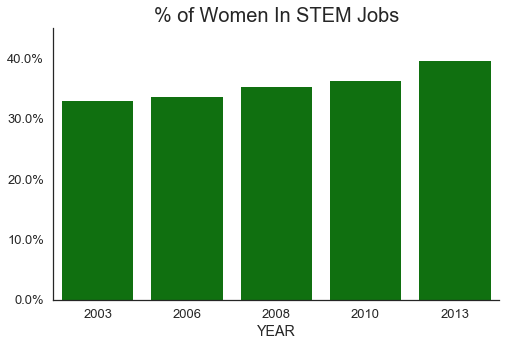

In [10]:
sns.set_style("white")
fig=plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)
df_female_percentage = df_stem[df_stem['LFSTATS']=='Employed'].groupby('YEAR')['GENDERS'].value_counts(normalize=True).unstack().reset_index()
sns.barplot(x='YEAR', y='Female', data = df_female_percentage, color="green", ax=ax)
ax.set_xlabel('YEAR')
ax.set_ylim([0,0.45])
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels(['{:1.1f}%'.format(x*100) for x in [0,0.1,0.2,0.3,0.4]])
plt.ylabel('')
plt.title('% of Women In STEM Jobs',fontsize=20)
sns.despine()
plt.savefig('./../results/femalepercent1.png',dpi = 150)
sns.set_style('whitegrid')

The bar plot shows about 33% of the STEM workers are women, from this set of data. The number differs from the 24% reported by the U.S. workforce. Several reasons could be contributing to it. First of all, there might be a gender bias in the volunteer based survey. There might simply be more men willign to take the survey than women. Also, the report by U.S. workforce might be based on a data from a different year.
Nevertheless, a increasing trend in the female percentage over the year (2003-2013) is present in this data set. There are more women working in the STEM job fields and it is encouraging!

### What is the unemployment rate for each gender from the STEM community?##


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


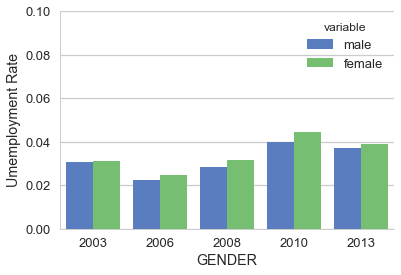

In [11]:
df_gender_employ = df.groupby(['YEAR','GENDERS'])['LFSTATS'].value_counts(normalize=True).unstack().reset_index()
LFW_map = {1: 0.0, 2: 1.0, 3: np.NaN}

df['LFSTATW'] = df['LFSTAT'].map(LFW_map)
#only consider the data in the labor force

df_inlf_only = df.dropna(subset=['LFSTATW'])

df_inlf_only['weighted_lfstats']=df_inlf_only['WEIGHT']*df_inlf_only['LFSTATW']

weighted_lfs = df_inlf_only.groupby(['YEAR','GENDERS'])[['weighted_lfstats']].sum().unstack().reset_index()
weight = df_inlf_only.groupby(['YEAR','GENDERS'])[['WEIGHT']].sum().unstack().reset_index()
female_unemployed_rate = weighted_lfs['weighted_lfstats']['Female']/weight['WEIGHT']['Female']
male_unemployed_rate = weighted_lfs['weighted_lfstats']['Male']/weight['WEIGHT']['Male']
d = {'Year': [2003, 2006, 2008, 2010, 2013], 'female': female_unemployed_rate, 'male': male_unemployed_rate}
df_unemployed_rate_weighted = pd.DataFrame(data=d)
#melt the data frame to get ready for seaborn barplot with hues
df_unemployed_rate_weighted_melt = pd.melt(df_unemployed_rate_weighted, id_vars=['Year'], value_vars=['female', 'male'])

sns.barplot(x='Year', y='value', hue='variable', data = df_unemployed_rate_weighted_melt, hue_order=['male','female'],palette="muted")
plt.xlabel('GENDER')
plt.ylim([0,0.1])
plt.ylabel('Umemployment Rate')
sns.despine()

The bar plot above shows the employment rate in the STEM community for the female and male groups. To keep consistent, the unemployed data does not take into account people not in the labor force. It indicates the unemployment rate for all is between 2-5% with around 1% higher rate for women than men. 

The unemployment rate here is about 50% less compared with the data from Bureau of Labor Statistics (https://data.bls.gov/pdq/SurveyOutputServlet). This might come from the survey bias. It could also mean the unemployment rate is lower in the STEM community compared with general population in US. 

### A closer look at the unemployment rate
We have already known that the female umemployment is higher than that of male. Now we take a closer look into the data, in specific, the undergraduate and graduate group data.

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

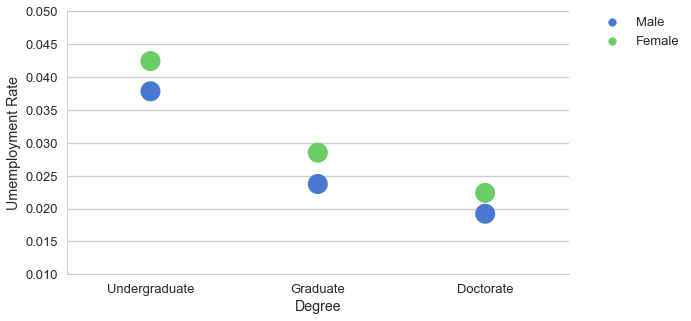

In [12]:
employ_ug = df_undergraduate.groupby('GENDERS')['LFSTATS'].value_counts(normalize=True).unstack()
employ_ug_melt = pd.melt(employ_ug.reset_index(), id_vars ='GENDERS')
employed_ug_melt_e = employ_ug_melt[employ_ug_melt['LFSTATS']=='Unemployed']
employed_ug_melt_e['Degree'] = 'Undergraduate'
employ_gr = df_graduate.groupby('GENDERS')['LFSTATS'].value_counts(normalize=True).unstack()
employ_gr_melt = pd.melt(employ_gr.reset_index(), id_vars ='GENDERS')
employed_gr_melt_e = employ_gr_melt[employ_gr_melt['LFSTATS']=='Unemployed']
employed_gr_melt_e['Degree'] = 'Graduate'
employ_dr = df_dr.groupby('GENDERS')['LFSTATS'].value_counts(normalize=True).unstack()
employ_dr_melt = pd.melt(employ_dr.reset_index(), id_vars ='GENDERS')
employed_dr_melt_e = employ_dr_melt[employ_dr_melt['LFSTATS']=='Unemployed']
employed_dr_melt_e['Degree'] = 'Doctorate'
employed_new = pd.concat([employed_ug_melt_e,employed_gr_melt_e,employed_dr_melt_e])

plt.figure(figsize=(8,4.5))
sns.stripplot(x='Degree', y='value', data=employed_new, hue='GENDERS', hue_order=['Male','Female'], size =20, palette="muted")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.tight_layout()
plt.ylim([0.01,0.05])
plt.ylabel('Umemployment Rate')

**Observations:**  
The dot plot shows the umemployment rate for both female and male in the undergraduate and graduate groups. The trend we see is that the higher the degree is, the lower the unemployment rate is. 

It is clear that the undergraduate group has a 1% unemployment rate difference in men and women. And the disparity stays about the same for the  graduate group. 

The last dot plot shows the unemployment rate for the doctorate group. In this case, the umemployment rate gap shrinks! Can we consider this to be an effective career advice for female students? 

### Gender Pay Gap
The box plot below shows the salary in the STEM community for the female and male groups between year 2003 and 2013. Note that the salary is capped at $150,000.



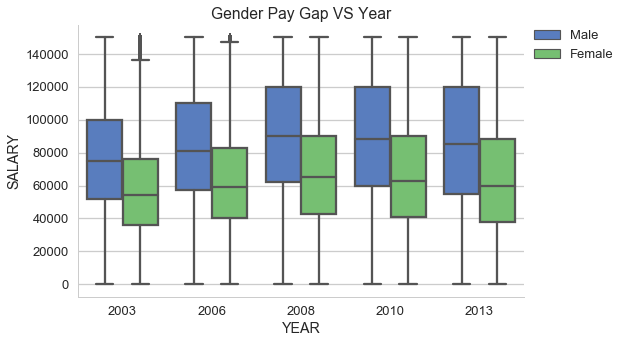

In [13]:
#bar plot of gender and salary 
fig=plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)
sns.boxplot(data=df, y = 'SALARY', x = 'YEAR', hue = 'GENDERS',hue_order=['Male','Female'], palette="muted", ax=ax)
sns.despine()
plt.title('Gender Pay Gap VS Year')
lgd=ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout
plt.savefig('./../results/gendersalary.png',bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 150)

** Highlights from the plot:**  
* Women have come a long way but are still not at parity. We have seen women's increased education and workforce participation. But the median, and the quatiles wages for men is about 30\% higher than women, for all years listed. The data from STEM survey loosely agrees with the nation wide findings of women making 78 cents for every 1 dollar men make.  
* There is NO shrinking trend in the gender discrepancies in these years.  
* The mean wages increased from year 2003 to 2008. Then we see a small decrease from 2008 to 2013. This makes sense considering the financial crisis in 2008. It is intersting to see the magnitude and how long it has been affecting the job market.  

In the analysis below we take a closer look at the salaries over the years, with different highest degree groups for STEMers.

### A close look: salary trend between 2003-2013 with degree group  

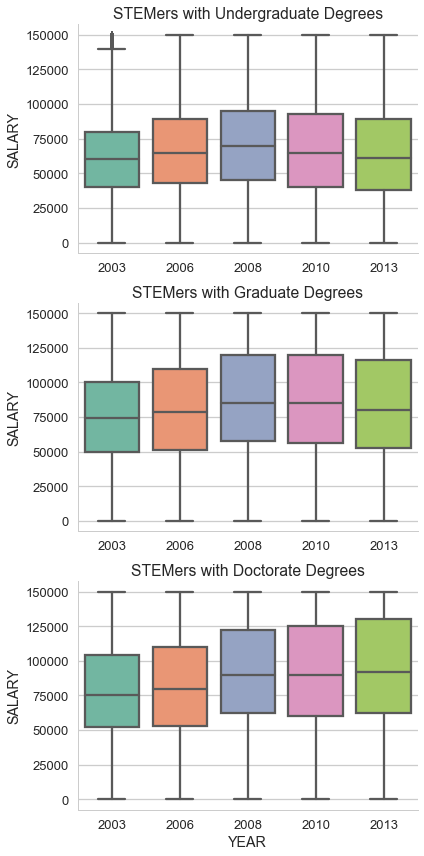

In [14]:
fig, axs = plt.subplots(nrows=3, figsize=(6,12))

#Plot undergraduate level salaries
sns.boxplot(data=df_undergraduate, y = 'SALARY', x = 'YEAR', palette="Set2", ax=axs[0])
axs[0].set_title('STEMers with Undergraduate Degrees')
axs[0].set_xlabel('')

#Plot graduate level salaries 
sns.boxplot(data=df_graduate, y = 'SALARY', x = 'YEAR', palette="Set2", hue_order=["Female", "Male"], ax=axs[1])
axs[1].set_title('STEMers with Graduate Degrees')
axs[1].set_xlabel('')


#Plot doctorate level salaries
sns.boxplot(data=df_dr, y = 'SALARY', x = 'YEAR', palette="Set2", ax=axs[2])
axs[2].set_title('STEMers with Doctorate Degrees')
axs[2].set_xlabel('YEAR')
sns.despine()

plt.tight_layout()

** A close look: salary trend between 2003-2013 with degree group **  


First of all, it is easy to see all the above plots give a steady increase in salary from year 2003 to 2008. But things get intereting after 2008. 

1. In the first subplot above, we see the salaries for individuals with undergraduate highest degree. It clearly indicates the trending down after year 2008. So how about STEMers with graduate degrees?

2. The second subplot shows the salary boxplot with graduate degrees (master, doctorate, and professional degrees). It also presents the downward trend between these years. Perhaps, a even closer looks is required. What about STEMers with doctorate degrees? 

3. The last subplot contains data from only the doctorate group. Now we see a **difference**! This bar plot did not show a down trend. Instead, the mean salary for year 2010 kept about the same as 2008 and an even an increased in 2013. 

In a financial crisis like this, the doctorate group in average was influenced least and recovered fastest. It gives some insights to the need for highly specialized professionals from our society. 

The plot below gives the same information on the women data. 



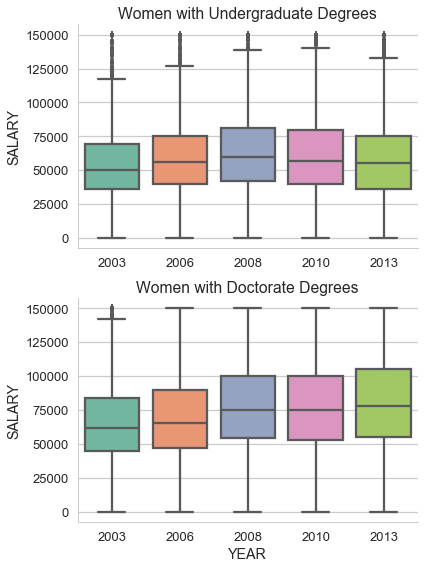

In [15]:
df_undergraduate = df_stem[(df_stem['DGRDG'] == 1)]
df_dr = df_stem[(df_stem['DGRDG'] == 3)]

fig, axs = plt.subplots(nrows=2, figsize=(6,8))

#Plot undergraduate level salaries
sns.boxplot(data=df_undergraduate[df_undergraduate['GENDERS']=='Female'], y = 'SALARY', x = 'YEAR', palette="Set2", ax=axs[0])
axs[0].set_title('Women with Undergraduate Degrees')
axs[0].set_xlabel('')


#Plot doctorate level salaries
sns.boxplot(data=df_dr[df_dr['GENDERS']=='Female'], y = 'SALARY', x = 'YEAR', palette="Set2", ax=axs[1])
axs[1].set_title('Women with Doctorate Degrees')
axs[1].set_xlabel('YEAR')
sns.despine()

plt.tight_layout()
plt.savefig('./../results/womensalary.png',dpi = 150)

Again, the salary decreased both years after the finacial crisis in 2008 but kept increasing for the doctorate groups. Jobs by people with higher education degrees are more resilient to a financial crisis, the same story for women employees. 

### Gender Pay Gaps and Racial Groups

(0, 100000)

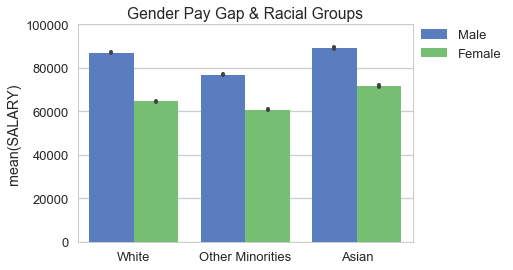

In [16]:

#Compare and plot the SALARY of races and genders from year 2003 
sns.barplot(data=df, y = 'SALARY', x = 'RACES', hue = 'GENDERS',hue_order=['Male','Female'], palette="muted")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title('Gender Pay Gap & Racial Groups')
plt.xlabel('')
plt.ylim([0,100000])

In [17]:
df_race = df.groupby(['RACES', 'GENDERS'])['SALARY'].mean().unstack()
df_race['Percentage'] = df_race['Female']/df_race['Male']
df_race

GENDERS,Female,Male,Percentage
RACES,,,
Asian,71786.489489,89006.353731,0.806532
Other Minorities,60773.480030,76820.061440,0.791115
White,64555.793021,86942.151196,0.742514


The box plot above shows the mean salary for both genders groups and three race categories. The table above lists the actual numbers. The percentage column tells us for every dollar men make, how much does women make? We already know from previous analysis: Men make more than women. 

Here is something new from the STEM survey data:

1. The pay gap between men and women exist in all race groups. 
2. The average salary for caucasion and asian men are about the same. The average salary for asian women is higher than the rest of female race groups. 
3. For every dollar asian men make, asian women make 81 cents.  
For every dollar white men make, white women make 74 cents.  
For every dollar other minorities(include black, hispanic, and etc) men make, other minorities women make 79 cents.  


### Unemployment rate of the female STEMers in different field of majors?

In [18]:
employ_female_2003 = df_2003[df_2003['GENDERS']=='Female'].groupby('MajorS')['LFSTATS'].value_counts(normalize=True).unstack().reset_index()

In [19]:
employ_female_2013 = df_2013[df_2013['GENDERS']=='Female'].groupby('MajorS')['LFSTATS'].value_counts(normalize=True).unstack().reset_index()

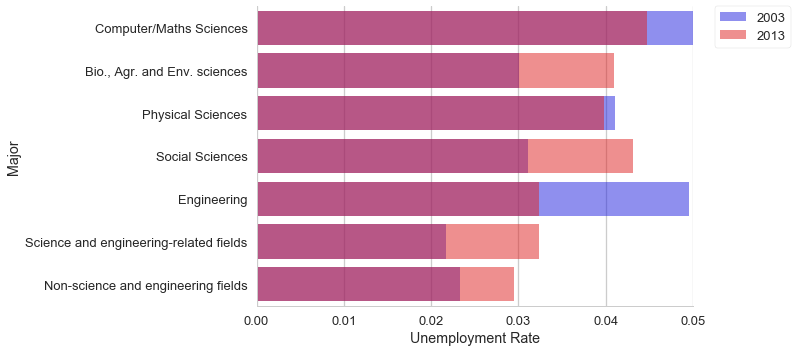

In [20]:
fig, axs = plt.subplots(figsize=(10,5))
field_order = ['Computer/Maths Sciences', 'Bio., Agr. and Env. sciences', 'Physical Sciences', 'Social Sciences', 'Engineering', 'Science and engineering-related fields', 'Non-science and engineering fields']
#Compare and plot the employment percentage for male and female college graduates
sns.set_color_codes("pastel")
sns.barplot( x="Unemployed",y="MajorS", order = field_order, alpha=0.5, data=employ_female_2003, color='blue', label='2003')


#Compare and plot the employment percentage for male and female doctor graduates
sns.set_color_codes("pastel")
sns.barplot(x="Unemployed", y="MajorS", order = field_order, alpha=0.5, data=employ_female_2013, color='red', label='2013')
axs.set(xlim=(0, 0.05), ylabel="Major",
       xlabel="Unemployment Rate")
sns.despine()
axs.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=True)
plt.tight_layout()

The plot shows the female unemployment rate for field of major groups in 2003 and 2013. This give us good information in what majors are having a better performance in job placement. 

Things worth noticing:
1. The unemployment rate for non-science and engineering fields major remained lowest both years. A closer look reveals this group contains job title such as 'Management' and 'Administration'. 
2. There is a significant decrease in the unemployment rate for the female engineering group (from 5% to 3%). 
3. Other groups who saw an decrease in unemployment rate from 2003 to 2013 is computer/maths sciences and physical science. All the other group either remained a similar or saw a higher unemployment rate.



### Comparison among principal job fields ## 

Here we take a look at how many male and female worker there are in different principal job fields according to the STEM survey.

In [21]:
df_job_gender = df.groupby('JobS')['GENDERS'].value_counts(normalize=True).unstack().reset_index()
df_job_gender_melt = pd.melt(df_job_gender, id_vars ='JobS')
job_order = ['Computer/Maths Sciences', 'Bio., Agr. and Env. sciences', 'Physical Sciences', 'Social Sciences', 'Engineering', 'Science and engineering-related fields', 'Non-science and engineering fields']

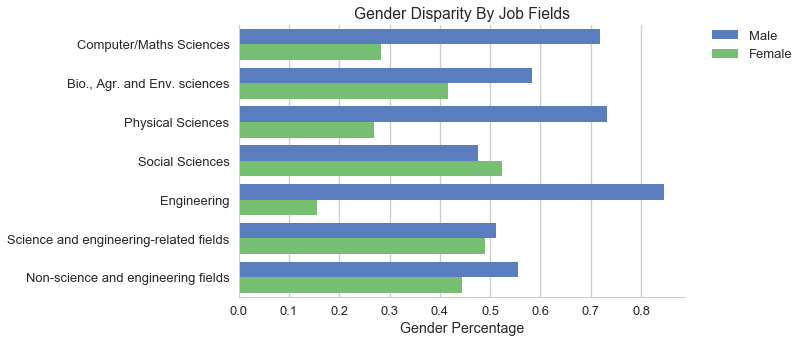

In [22]:
#Compare and plot the gender percentage in STEM jobs.
fig=plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)
sns.barplot(y='JobS', x='value', data=df_job_gender_melt, hue='GENDERS', hue_order=['Male','Female'], ax=ax, order=job_order, palette="muted")
plt.title('Gender Disparity By Job Fields')
plt.xlabel('Gender Percentage')
plt.ylabel('')
lgd=ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.savefig('./../results/genderdisparitybyfield.png',bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 150)
#look at detailed group for explanation https://highered.ipums.org/highered-action/variables/NOCPR#codes_section 

** Wow! The job fields that have the most gender imbalance are: engineering, computer/maths sciences and physical sciences. There are four point six men for each woman working in Engineering field!**

### Gender Pay Gap by Fields## 


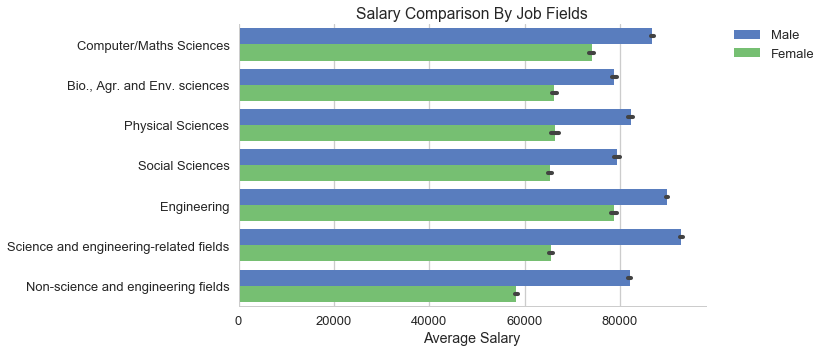

In [23]:
#plot of salary VS type of job 
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
sns.barplot(y="JobS", x="SALARY", data=df, hue="GENDERS", order=job_order, hue_order=['Male','Female'],ax=ax, palette="muted")
lgd=ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Salary Comparison By Job Fields')

plt.xlabel('Average Salary')
plt.ylabel('')
sns.despine()
plt.tight_layout()
plt.savefig('./../results/salarycomparisonbyfield.png',bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 150)

Here we find:
1. The job fields that have the least pay gap between men and women are: engineering, computer/maths sciences and bio/life sciences.
2. Engineering field gives the best compensation to their female employees compared with other jobs. 
3. In the meantime, the lowest pay check for females goes to non-science and engineering field. The discrepancy in the compensation for male and female groups also goes to the same field. Recall that this group contains job title such as 'Management' and 'Administration'. This could be indicating the even severe gender disparity in management positions.

<a id='stats'></a>
## Statistical Analysis ##

The exploratory data analysis above studied on several questions we have on women in STEM. 

To name a few discoveries:
* Women have been more active in the STEM job field over the years. 
* There is an apparent gender umployment gap and gender pay gap from this survey results.
* The situation is different for different principal job fields. 

However, almost all the conclusion above were made with visualization tools. While visualization is powerful and easy to understand, we need statistical tools to back our conclusions. In the following chapter, I am using scientific analysis to find whether our findings are statistically significant. We will also discuss whether the result is practically significant which could be important to help making decisions. 

for individual statistical analysis notebook, please click [HERE](https://github.com/shuojiashi/capstone_project_1/blob/master/notebooks/Women%20in%20STEM_2%20Statistics.ipynb)

### Is gender umemployment gap statistically significant? ##


<p>This is a problem with two categorical columns. It would involve a $\chi ^2$ test to find whether the result is statistically significant.</p>

First we define the null hypothesis: 
$$H_0: p_m = p_f$$ 
The gender does not make a difference in the umemployment rate.

And the alternative hypothesis:
$$H_0: p_m \neq p_f$$
There is a correlation in gender and unemployment rate.

Use the chi2 modual from the scipi package, the p-value is ealiy found. 

To remind ourselves, we put the plot here again.

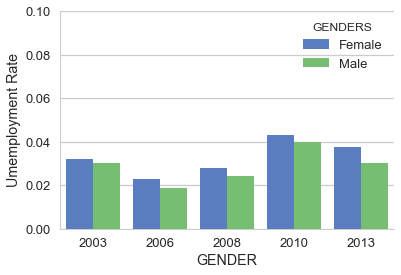

In [24]:
#count plot of employed and unemployed entries for genders.
sns.barplot(x='YEAR', y='Unemployed', hue='GENDERS', data = df_gender_employ, palette="muted")
plt.xlabel('GENDER')
plt.ylim([0,0.1])
plt.ylabel('Umemployment Rate')
sns.despine()

Now calculate the statistical terms, using $\chi^2$ test:

In [25]:
cont_table = pd.crosstab(index=df.GENDERS, columns=df.LFSTATS)
chi2, pval, _, _ = stats.chi2_contingency(cont_table)
print("Chi-squared test statistic: {}".format(chi2))
print("p-value: {}".format(pval))

Chi-squared test statistic: 69.44698387052611
p-value: 7.849633922911248e-17


#### The above results shows the p-value is practically zero. 
$$p < \alpha $$ 
The null hypothesis is rejected in this case.   
** There is a statistical significance in the difference of unemployment rate for men and women. **  
The unmployment gap is small (<1%).

### Is gender pay gap statistically significant? ##

We look into the salary gap between men and women in the survey data. Box plot gives a clear indication: there is a gender pay gap!

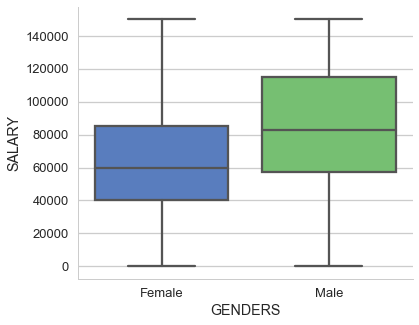

In [26]:
#bar plot of gender and salary 
plt.figure(figsize=[6,5])
sns.boxplot(data=df, y = 'SALARY', x = 'GENDERS', palette="muted")
sns.despine()

How about statistically?

Define null hypothesis as men and women report the same average salary over the years:
$$s_m = s_f$$
Alternative hypothesis:
$$s_m \neq s_f$$

Now it's time for the two sample t test for the difference of means:

In [27]:
salary_m = df[df['GENDERS']=='Male']['SALARY']
salary_f = df[df['GENDERS']=='Female']['SALARY']
diff_perc_s = (np.mean(salary_m)-np.mean(salary_f))/np.mean(salary_f)
print('The mean salary for men is {0:.2f} % higher than that of women.'.format(round(diff_perc_s*100,2)))
stats.ttest_ind(salary_m.dropna(), salary_f.dropna(),  equal_var = False)

The mean salary for men is 32.38 % higher than that of women.


Ttest_indResult(statistic=172.80152812858356, pvalue=0.0)

It's found that pvalue is practically zero. The null hypothesis is rejected.   

** There is a significant difference in the average pay between men and women. **  

The difference of means, also calculated above, is 32%. We say this is not only statistically significant, but also practically significant!

The result above will also help with the feature selection when we predict salary level. In later chapter, We will run similar test across all the attributes and choose only statistically significant ones. 

### Is gender job satisfaction gap statistically significant?

First we check the visualization for gender job satisfaction gap. 

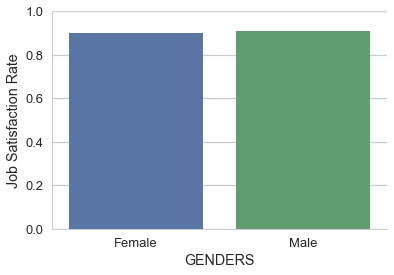

In [28]:
#how many people are satisfied with their jobs
df_graduate_satisfy = df.groupby('GENDERS')['JobSatis'].value_counts(normalize=True).unstack().reset_index()
sns.barplot(x='GENDERS', y='Satisfied', data=df_graduate_satisfy)
plt.ylim([0,1])
plt.ylabel('Job Satisfaction Rate')
sns.despine()

** The above plot shows both men and women have a high (about 90%) job satisfaction rate in STEM.**

** The difference bewteen the genders is small. **

** Is the there a statistically significant difference?**

The null hypothesis here: the job statisfaction rate remains the same for male and female employees in the STEM field. 
$$js_m = js_f$$

In [29]:
df_satis = df[pd.notnull(df['JobSatis'])]
cont_table = pd.crosstab(index=df_satis.GENDERS, columns=df_satis.JobSatis, normalize='index')
print(cont_table)
cont_table2 = pd.crosstab(index=df_satis.GENDERS, columns=df_satis.JobSatis)
chi2, pval, _, _ = stats.chi2_contingency(cont_table2)
print("Chi-squared test statistic: {}".format(chi2))
print("p-value: {}".format(pval))

JobSatis  Dissatisfied  Satisfied
GENDERS                          
Female        0.098798   0.901202
Male          0.089292   0.910708
Chi-squared test statistic: 103.0209000980635
p-value: 3.3163113124478954e-24


We find the p-value so small that the null hypothesis is easily rejected. The story once again points at the alternative hypothesis.  
** The  difference of the job satisfaction between men and women STEMers is statistically significant. **  

However, we see both from the bar plot and the calculation, the difference is merely 1%. Does this statistically sound disparity really mean anything in the real world? Should we make any executive decisions or suggestions based on this data analysis? My answer to this is not really. The difference is so small that we can not say either gender is actually happier with their jobs than the other gender group.  

It is surprising that with the large gender pay gap, women and men report similar job satisfaction rate. I would not be happy with my job if I know my male colleages are taking home much more even though our are job descriptions are basically the same. Why is it happening? Do the general population lack access to the gender pay gap information?

#### Above, several aspects of the exploratory data analysis on the STEM higher education data set were put on statistical test.    
The disparity in unemployment rate, salary and job satisfaction between males and females all turned out to be statistically significant. The consistent statistical significance may come from the large sample number of the data set. Although one test proven to be statistically significant does not mean it is practically significant. It is always a good idea to discuss the actual meaning of the test results and whether the effect needs to be addressed. 

Now we are ready to use machine learning models to predict the salary level and job field using this survey data!

<a id='ml'></a>
## Machine Learning: Predict income and field of work

We have looked at the STEM gender pay gap over the years in the EDA part. Even though women has taking up bigger part among the jobs between the years of 2003 and 2013, women make about 78 cent for every dollar men make! The analysis also shows how the gender gap compare to one another in the various fields in STEM areas. 

In this chapter, I will explore using machine learning models to predict the income and principal job field given other aspects of the data. It would answer the question of what kind of pay and what types of job would a STEMer expect to receive in the work force.

for individual machine learning notebook, please click [HERE](https://github.com/shuojiashi/capstone_project_1/blob/master/notebooks/Women%20in%20STEM_3%20Machine%20Leanring.ipynb)

<a id='dpsp'></a>
### Feature Selection

In [30]:
# list of column names from the survey data
df_employed_l.columns

Index(['YEAR', 'SAMPLE', 'SURID', 'AGE', 'BIRYR', 'GENDER', 'MINRTY', 'RACETH',
       'BTHUS', 'CTZUSIN', 'NBAMED', 'NBAMEMG', 'DGRDG', 'HD03Y5', 'NDGMED',
       'NDGMEMG', 'HRSWKGR', 'WKSWKGR', 'OCEDRLP', 'NOCPR', 'NOCPRMG',
       'SALARY', 'JOBSATIS', 'EMSEC', 'EMSIZE', 'GOVSUP', 'WAPRSM', 'ACTCAP',
       'ACTDED', 'ACTMGT', 'ACTRD', 'ACTRDT', 'ACTRES', 'ACTTCH', 'WKTRNI',
       'WAPRI', 'WASEC', 'WASCSM'],
      dtype='object')

In [31]:
# Quick correlation check:
print('Top correlated:')
print(df_employed_l.corr()['SALARY'].sort_values(ascending=False).head(6))
print('Top reverse correlated:')
print(df_employed_l.corr()['SALARY'].sort_values(ascending=True).head(5))

Top correlated:
SALARY     1.000000
HRSWKGR    0.403946
DGRDG      0.263496
GENDER     0.257586
EMSEC      0.215927
SURID      0.193761
Name: SALARY, dtype: float64
Top reverse correlated:
ACTTCH   -0.183005
WAPRI    -0.172204
HD03Y5   -0.167808
BIRYR    -0.162161
WASCSM   -0.141206
Name: SALARY, dtype: float64


This is interesting already! We see the top five positively correlated features include full time job status (HRSWKGR: hours worked per week), degree (DGRDG and SURID), gender, and employer sector (EMSEC). 

I would like to point out gender apparently made it to the top three correlated feature deciding a salary: being a man is likely to receive a higher pay than woman. This is another indicator of the pay disprancy between genders. Another insight from this is how the employer sector is playing an important role. The expected pay is lowest if working in a school system, higher if working for the govenment, and highest if working for business and industry.

Among the top negatively correlated columns, the first place goes to teaching as prime job activity. Other columns also more or less has teaching in its reason for making the list (expect for birth year). This resonates with the discovery from the positively correlated employer sector. This gives a supporting evidence of how teachers or people who teach are given lower compensation among jobs, for the ongoing teacher strike across the country. 

** Target column preparation**   


Here I change salary from a numeric column to a catagorical column. Due to privacy reason, the survey on scientists and engineers provided by Higher Education do not contain location data. As common knowledge tells us, the location could be a large factor in deciding how much a person is getting paid. The cost of living of San Francisco is more than two times that of Omaha, as an example. It is only fair that people in high cost of living areas get better paid than people in low cost of living places. Since this crucial piece of information is missing, it adds a lot of uncertainty into the prediction of the salary. 

To make the task practically possible, I am going to predict the salary level (low or high), instead of the exact number. 

I have also done some work that looks into the prediction of numeric salary using several regression models. It gave limited the accuracy scores due to above reasons. Please find the details in regression notebook in the same folder if interested.

In [32]:
# define a function change the salary column to a salary level column
def salary_bracket(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s<60000:
            new_s[i] = 0
        else:
            new_s[i] = 1
    return new_s

# define a dataframe only contains salary that is larger than 0 (eliminate the entry fault)
df_employed_clf =[]
df_employed_clf = df_employed_l[(df_employed_l['SALARY']>0)]



new_salary = salary_bracket(df_employed_clf['SALARY'])

We define a new dataframe that is similar to the previous one except for it contains only the salary level column. Note the birth year column (BIRYR) is a dependent variable on YEAR and AGE. This column is dropped blow. Some major groups columns is also dependent on the other columns in the survey data, they will be dropped as well.
In the meantime, we choose the part of the data considering only full time jobs (hours per week >=36).
In [10]:

In [33]:
df_employed_nod = []
df_employed_nod = df_employed_clf.assign(salary_d=pd.Series(new_salary).values)
df_employed_nod.salary_d = df_employed_nod.salary_d.astype('category')
df_employed_nod=df_employed_nod.drop(['SALARY'], axis=1)
df_employed_nod=df_employed_nod.drop(['BIRYR','NBAMEMG','NDGMEMG','NOCPRMG'], axis=1)
df_employed_nod=df_employed_nod[(df_employed_nod['HRSWKGR']==3) | (df_employed_nod['HRSWKGR']==4)]

A quick look at the distribution of the pay between men and women. Much more men were paid above 60k income than women while the count of women and men paid below 60k remain similar. This also gives that more entries report higher than 60k salary than below 60k.

<function matplotlib.pyplot.tight_layout>

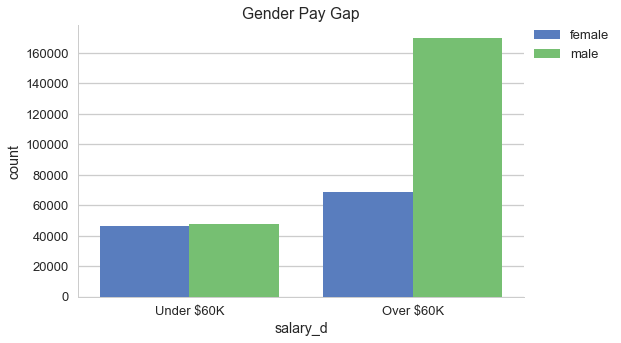

In [34]:
#bar plot of gender and salary 
fig=plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)
sns.countplot(data=df_employed_nod, x = 'salary_d', hue= 'GENDER', palette="muted", ax=ax)
sns.despine()
plt.title('Gender Pay Gap')
ax.set_xticklabels(['Under $60K', 'Over $60K'])
lgd=ax.legend(['female', 'male'], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout
#plt.savefig('./../results/gendersalary.png',bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 150)


It is obvious from the plot above that there are much more men making more than $60k a year compared than women. We have learned from the EDA notebook that the gender pay gap exists and did not improve over the years from 2003 to 2013. This is another quick look at it. Please find the EDA notebook if you are looking for more details on this matter. 

** Numeric Columns**

In [35]:
#define the numeric column
numeric = ['AGE']
feature_df = df_employed_nod.drop(['salary_d'],axis=1)

#the rest is categorical 
categoric = feature_df.columns.difference(numeric)

I look into the numeric column and check its distribution. The age profile in this data set is not really normal distribution. It is caused by the nature human behavior, people usually do not start working after college, some people tend to stay in the work force longer than the other. So we see a jump at 25 and a long tail after 60. The good news is that our survey data is large (391,000 entries), the null hypothesis will work here according to the central limit theorem (CLT). 

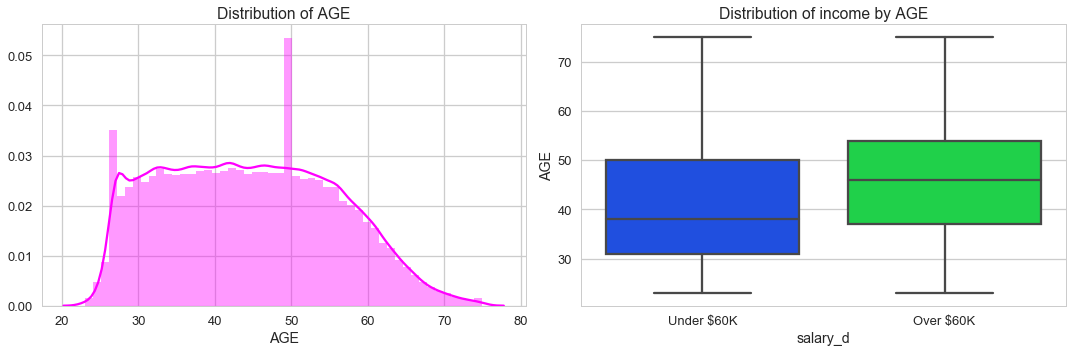

P-values from t-tests


,Attribute,P_value
0,AGE,0.0


In [36]:
p_vals = pd.DataFrame(columns=['Attribute', 'P_value'])

for col in numeric:
   
    # Plotting distributions of each column
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.distplot(df_employed_nod[col], color='magenta')
    plt.title('Distribution of {}'.format(col))

    # Plotting distributions of each column by income level
    plt.subplot(122)
    g = sns.boxplot(x='salary_d', y=col, data=df_employed_nod, palette='bright')
    g.set_xticklabels(['Under $60K', 'Over $60K'])
    plt.title('Distribution of income by {}'.format(col))
    plt.tight_layout()
    plt.show()

    # Calculating pvalues from t-test
    t_val, p_val = ttest_ind(df_employed_nod[df_employed_nod['salary_d']==0][col],
                                df_employed_nod[df_employed_nod['salary_d']==1][col])
    p_vals = p_vals.append({'Attribute':col, 'P_value':float(p_val)}, ignore_index=True)
    

# Printing p-values of t-tests, sorted by p-values
print('P-values from t-tests')
p_vals.sort_values('P_value')



The p_value for the numeric column is practically zero, which means age is statistically significant to determine the salary level of an individual. We will keep it as it is.

** Categorical columns**

Next we prepare the categorical feature columns for classification. We are going to convert these categorical variable into dummy/indicator variables, calling the get_dummies function by pandas (thank you Pandas!). Note the drop_first parameter was set to true to avoid collinearity.

In [37]:
feature_df = df_employed_nod.drop(['salary_d'],axis=1)
categoric = feature_df.columns.difference(numeric)
df_employed_nod_sig = pd.get_dummies(data=df_employed_nod, columns=categoric, drop_first=True)
df_employed_nod_sig.head()

,AGE,salary_d,ACTCAP_1.0,ACTDED_1.0,ACTMGT_1.0,ACTRD_1.0,ACTRDT_1.0,ACTRES_1.0,ACTTCH_1.0,BTHUS_1,...,WASEC_14.0,WASEC_15.0,WKSWKGR_2.0,WKSWKGR_3.0,WKSWKGR_4.0,WKTRNI_1.0,YEAR_2006,YEAR_2008,YEAR_2010,YEAR_2013
0,47,0.0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1,66,1.0,0,1,1,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,60,1.0,1,0,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
3,30,1.0,0,1,0,1,1,1,0,1,...,0,0,0,0,1,1,0,0,0,0
5,51,1.0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0


Next, we go through all the dummied categorical variables and do the $\chi^2$ test with the salary level column. The purpose is to filter out attributes that statistically insignificant. This will simplify our model.

In [38]:
p_vals_cate = pd.DataFrame(columns=['Attribute', 'P_value'])
categoric = df_employed_nod_sig.columns.difference(['AGE','salary_d'])
p_large = []

for col in categoric:
    # Creating cross tabulated data for Chi-square test
    counttable = pd.crosstab(df_employed_nod_sig[col], df_employed_nod_sig['salary_d'])
    chi2, p, dof, ex = chi2_contingency(counttable, correction=False)
    p_vals_cate = p_vals_cate.append({'Attribute':col, 'P_value':float(p)}, ignore_index=True)
    if p>0.01:
         p_large.append(col)
    
# Printing p-values of Chi-squared tests, sorted by p-values
print('P-values from Chi-Squared Contingency Tests')
print(p_vals_cate.sort_values('P_value', ascending=False).head(10))

print('info of df before deleting insignificant attributes:')
print(df_employed_nod_sig.info())

df_employed_nod_sig_2  = df_employed_nod_sig.drop(p_large, axis=1)

print('info of df after:')
print(df_employed_nod_sig_2.info())

P-values from Chi-Squared Contingency Tests
          Attribute   P_value
115      SAMPLE_801  0.851496
25      HD03Y5_1956  0.427363
76    NDGMED_611995  0.284468
87   NOCPR_393995.0  0.108034
89   NOCPR_432360.0  0.104620
145      WASEC_13.0  0.071465
137      WASCSM_2.0  0.071465
153       WASEC_7.0  0.064534
26      HD03Y5_1961  0.060264
3        ACTRDT_1.0  0.039083
info of df before deleting insignificant attributes:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 333044 entries, 0 to 478746
Columns: 166 entries, AGE to YEAR_2013
dtypes: category(1), int64(1), uint8(164)
memory usage: 67.5 MB
None
info of df after:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 333044 entries, 0 to 478746
Columns: 152 entries, AGE to YEAR_2013
dtypes: category(1), int64(1), uint8(150)
memory usage: 63.0 MB
None


As we can see above, fourteen columns are deleted because their Chi-Squared cntingency tests p-value is larger than defined significance level (0.01). These statistically insignificant features include certain part of the survey, some secondary job activities, certain some majors and etc..

<a id='psl'></a>
### Predict Salary Level


Next we define the target coloumn and the feature columns, using the results from the feature selection. Scikit-learn's train_test_split makes it easy to separate the data into training and test data.  
Before we proceed to the next step, recall that the distribution of the salary level: there are more entries with higher than 60k salary level. The inbalance will cause under sampling. To avoid this, use the RandomUnderSampler function to ensure we are choosing the same amount of entries from both target classes.

** Train Test Split**

Next we define the target coloumn and the feature columns, using the results from the previous preparation. Scikit-learn's train_test_split makes it easy to separate the data into training and test data.
Before we proceed to the next step, recall that the distribution of the salary level: there are more entries with higher than 60k salary level. The inbalance will cause under sampling. To avoid this, use the RandomUnderSampler function to ensure we are choosing the same amount of entries from both target classes.

In [39]:
df_employed_nod_sig_3 = df_employed_nod_sig_2#.sample(frac=0.1, random_state=42)

# Identify variables
X = df_employed_nod_sig_3.drop('salary_d', axis=1)
y = df_employed_nod_sig_3.salary_d

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)
X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)

print('Raw Training Set Percent Under $60,000: {:.1f}%'.format(
    len(y_train[y_train == 0])/len(y_train)*100))
print('Resampled Training Set Percent Under $60,000: {}%'.format(
    len(y_rus[y_rus == 0])/len(y_rus)*100))

Raw Training Set Percent Under $60,000: 28.7%
Resampled Training Set Percent Under $60,000: 50.0%


In [40]:
# Initiate list to store the training and testing scores for classification models
score_train = []
score_test = []

With the data prepared, we will proceed to test with several classification models. I will find the accuracy score using logistic regression, random forest classifier, KNN, and AdaBoost classifier. For each model, the cross validated grid search will be called find the best parameters. Then the found parameters are fed back into the model for prediction of the test data.  

#### Logistic Regression


In [41]:
clf = LogisticRegression()
parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

#initiate a instance for classifier using the optimized parameters
clf = LogisticRegression(**best_params)

# Fit the classifier to the training data
clf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

scores_LR_train = cross_val_score(clf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                            scores_LR_test.std()*2))

score_train.append(scores_LR_train.mean())
score_test.append(scores_LR_test.mean())

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Best Score: 0.78095902354
Best Parameters: {'C': 10, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}
Cross Validation Accuracy Scores - Training Set: 0.78174(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.81533(+/- 0.00)
Confusion matrix on the test data:
[[ 51466  14097]
 [ 37430 130138]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.58      0.78      0.67     65563
        1.0       0.90      0.78      0.83    167568

avg / total       0.81      0.78      0.79    233131



By checking the logistic regression coefficient, we can take a glance at the features that contribute most to the classification of our target.


In [42]:
# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'Coef']
# Calculating exponentiated coefficients for interpretation
coefs_lg['Odds_Ratios'] = np.exp(coefs_lg['Coef'])
print('\nFeatures with the most impact on higher income levels')
coefs_lg.sort_values('Odds_Ratios', ascending=False).head(6)


Features with the most impact on higher income levels


,Attribute,Coef,Odds_Ratios
21,EMSIZE_8.0,2.049162,7.761397
11,DGRDG_4,2.011932,7.477754
20,EMSIZE_7.0,1.726152,5.618988
10,DGRDG_3,1.691709,5.428751
19,EMSIZE_6.0,1.556426,4.741845
14,EMSEC_4.0,1.531416,4.624721


The result is insightful! We found:

1. professional or doctorate degrees both play a important positive role in being classified into the higher salary level. 

2. The size of the employer is another important attribute: Chances are you will get a better pay working for a large coorporate employer (large than 5000 employees). 

3. The last feature among the top five positive impact is the principal job field. Being the science and engineering manager is advantageous to receiving a higher salary, which is reasonable and inspiring.

#### Random Forest Classifier

In [43]:
#Random forest classifier parameter optimization:

rf = RandomForestClassifier()
param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [10, 30, 50],
              "max_depth": [10, 100, 300]
              }

grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_rf.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

Best Score: 0.785126416739
Best Parameters: {'max_depth': 300, 'max_features': 10, 'n_estimators': 75}


In [44]:
#initiate a instance for classifier
rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test)

scores_rf_train = cross_val_score(rf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

score_train.append(scores_rf_train.mean())
score_test.append(scores_rf_test.mean())

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Cross Validation Accuracy Scores - Training Set: 0.78378(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.82531(+/- 0.00)
Confusion matrix on the test data:
[[ 51452  14111]
 [ 35369 132199]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.59      0.78      0.68     65563
        1.0       0.90      0.79      0.84    167568

avg / total       0.82      0.79      0.80    233131



#### KNN

In [45]:
#KNN parameter optimization
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": [5, 10, 15],
              "leaf_size": [10, 30, 50],
              "weights": ['uniform', 'distance']
              }


grid_knn = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_knn.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_knn.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_knn.best_params_
print('Best Parameters:', best_params)

#initiate a instance for classifier
knn = KNeighborsClassifier(**best_params)

# Fit the classifier to the training data
knn.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test)

scores_knn_train = cross_val_score(knn, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_knn_train.mean(), 
                                                                                 scores_knn_train.std()*2))
scores_knn_test = cross_val_score(knn, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_knn_test.mean(), 
                                                                                 scores_knn_test.std()*2))

score_train.append(scores_knn_train.mean())
score_test.append(scores_knn_test.mean())

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Best Score: 0.744864864865
Best Parameters: {'leaf_size': 50, 'n_neighbors': 15, 'weights': 'distance'}
Cross Validation Accuracy Scores - Training Set: 0.74486(+/- 0.00)
Cross Validation Accuracy Scores - Test Set: 0.79986(+/- 0.00)
Confusion matrix on the test data:
[[ 46543  19020]
 [ 35723 131845]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.57      0.71      0.63     65563
        1.0       0.87      0.79      0.83    167568

avg / total       0.79      0.77      0.77    233131



#### Adaboost

In [46]:
# Parameter optimization
param_grid = {
              "n_estimators": [10, 100, 200]
             }


ABC = AdaBoostClassifier()

# run grid search
grid_ab = GridSearchCV(ABC, param_grid=param_grid)

grid_ab.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_ab.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_ab.best_params_
print('Best Parameters:', best_params)

#initiate a instance for classifier

ab = AdaBoostClassifier(**best_params)

# Fit the classifier to the training data
ab.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = ab.predict(X_test)

scores_ab_train = cross_val_score(ab, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_ab_train.mean(), 
                                                                                 scores_ab_train.std()*2))
scores_ab_test = cross_val_score(ab, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_ab_test.mean(), 
                                                                                 scores_ab_test.std()*2))

score_train.append(scores_ab_train.mean())
score_test.append(scores_ab_test.mean())

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Best Score: 0.778308631212
Best Parameters: {'n_estimators': 200}
Cross Validation Accuracy Scores - Training Set: 0.77932(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.81329(+/- 0.00)
Confusion matrix on the test data:
[[ 51145  14418]
 [ 37346 130222]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.58      0.78      0.66     65563
        1.0       0.90      0.78      0.83    167568

avg / total       0.81      0.78      0.79    233131



#### Model Comparison

In [47]:
models = ['Logistic Regression', 'Random Forest Classifier', 'KNN', 'AdaBoost']
model_comp = pd.DataFrame(
    {'model_name': models,
     'Accuracy score on train': score_train,
     'Accuracy score on test': score_test
    })

print(model_comp)

   Accuracy score on test  Accuracy score on train                model_name
0                0.815327                 0.781744       Logistic Regression
1                0.825313                 0.783784  Random Forest Classifier
2                0.799859                 0.744865                       KNN
3                0.813290                 0.779320                  AdaBoost


Looks like the accuracy scores highest at 0.78 on train data by Random Forest Classifier. Consider we are missing a vital piece of information in determining income, the location, the accuracy score is not bad! KNN can't quite compare with the other models for the dimensionality of the survey data.
Next we check the ROC curve of the results from above models. It will give more insight into how well the models work.

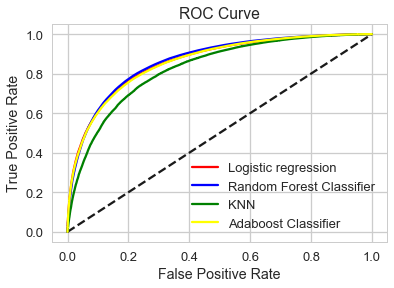

In [48]:
## prepare ROC curve plot
y_pred_prob_lg = clf.predict_proba(X_test)[:,1]
y_pred_prob_rf = rf.predict_proba(X_test)[:,1]
y_pred_prob_knn = knn.predict_proba(X_test)[:,1]
y_pred_prob_ab = ab.predict_proba(X_test)[:,1]


# Generate ROC curve values: fpr, tpr, thresholds
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_pred_prob_lg)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_prob_knn)
fpr_ab, tpr_ab, thresholds_ab = roc_curve(y_test, y_pred_prob_ab)


# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lg, tpr_lg, 'red', label='Logistic regression')
plt.plot(fpr_rf, tpr_rf, 'blue', label='Random Forest Classifier')
plt.plot(fpr_knn, tpr_knn, 'green', label='KNN')
plt.plot(fpr_ab, tpr_ab, 'yellow', label='Adaboost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

#### Predict the salary level among women employees in 2013:

It is now a good time to run the model with the latest data for women employees. Nevertheless, the focus of this project is women in STEM workforce and we can get the most related insight using the most recent data. So next, we choose the women and year 2013 in the survey data and use logistic regression to predict the salary level.

In [49]:
df_employed_nod_sig_3 = df_employed_nod_sig_2
# Identify variables
X = df_employed_nod_sig_3[(df_employed_nod_sig_3['GENDER_2']==0)&(df_employed_nod_sig_3['YEAR_2013']==1)].drop('salary_d', axis=1)
y = df_employed_nod_sig_3[(df_employed_nod_sig_3['GENDER_2']==0)&(df_employed_nod_sig_3['YEAR_2013']==1)].salary_d

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)

print('Raw Training Set Percent Under $60,000: {:.1f}%'.format(
    len(y_train[y_train == 0])/len(y_train)*100))
print('Resampled Training Set Percent Under $60,000: {}%'.format(
    len(y_rus[y_rus == 0])/len(y_rus)*100))

clf = LogisticRegression()
parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

#initiate a instance for classifier
clf = LogisticRegression(**best_params)
#clf = RandomForestClassifier(n_estimators=50, max_depth=100)

# Fit the classifier to the training data
clf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

scores_LR_train = cross_val_score(clf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, X_test, y_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                                 scores_LR_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_test, y_pred))

Raw Training Set Percent Under $60,000: 39.7%
Resampled Training Set Percent Under $60,000: 50.0%
Best Score: 0.770153680237
Best Parameters: {'C': 0.1, 'fit_intercept': True, 'solver': 'lbfgs'}
Cross Validation Accuracy Scores - Training Set: 0.77231(+/- 0.02)
Cross Validation Accuracy Scores - Test Set: 0.78690(+/- 0.01)
Confusion matrix on the test data:
[[ 6701  1983]
 [ 2910 10208]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.70      0.77      0.73      8684
        1.0       0.84      0.78      0.81     13118

avg / total       0.78      0.78      0.78     21802



In [50]:
# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'Coef']
# Calculating exponentiated coefficients for interpretation
coefs_lg['Odds_Ratios'] = np.exp(coefs_lg['Coef'])
print('\nFeatures with the most impact on higher income levels for women')
coefs_lg.sort_values('Odds_Ratios', ascending=False).head(5)


Features with the most impact on higher income levels for women


,Attribute,Coef,Odds_Ratios
11,DGRDG_4,1.410681,4.098745
10,DGRDG_3,1.034858,2.814707
21,EMSIZE_8.0,0.979350,2.662724
14,EMSEC_4.0,0.952613,2.592476
9,DGRDG_2,0.754761,2.127104


The accuracy scores and most contributing attributes with women only data are very similar to the model ran with the entire survey data. 

<a id='ppjf'></a>
### Predict the Principal Job Field

Suppose you are a college student, what would you expect when you go to the workforce? Are you going to work on major related fields? Here we are going to answer this question by using machine learning models on the pre-employment portion of the data.


** Data Preparation**

Here we are planning to predict the field of work for an individual looking for a job, a soon-to-be college graduate for example. This indicates that we don't have any information about the jobs for that person.

In [51]:
# Use only columns that are pre-employment. 
# Choose the target column 'NOCPRMG'

df_employed_nod = df_employed_clf[['YEAR', 'SAMPLE', 'SURID', 'AGE', 'GENDER', 'MINRTY', 'RACETH',
       'BTHUS', 'CTZUSIN', 'NBAMED', 'NBAMEMG', 'DGRDG', 'HD03Y5', 'NDGMED',
       'NDGMEMG', 'NOCPRMG']]


# numeric columns
numeric = ['AGE']
# categoric columns
categoric = df_employed_nod.drop(['NOCPRMG'],axis=1).columns.difference(numeric)

In [52]:
# change categorical features to dummied columns
df_employed_nod_sig = pd.get_dummies(data=df_employed_nod, columns=categoric, drop_first=True)
df_employed_nod_sig.head()

,AGE,NOCPRMG,BTHUS_1,CTZUSIN_1,DGRDG_2,DGRDG_3,DGRDG_4,GENDER_2,HD03Y5_1951,HD03Y5_1956,...,SAMPLE_802,SAMPLE_901,SAMPLE_902,SAMPLE_1001,SAMPLE_1002,SURID_2,YEAR_2006,YEAR_2008,YEAR_2010,YEAR_2013
0,47,2.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,4.0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,60,6.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,5.0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,51,5.0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Take NOCPRMG = 2 as a first look at the problem. The target column indicates whether the principal job field of the individual is biological, agricultural and other life sciences.

In [53]:
# define a function to find for a certain type job field only. 
# NOCPRMG = 1, Computer and mathematical scientists
# NOCPRMG = 2, Biological, agricultural and other life scientists
# NOCPRMG = 3, Physical and related scientists
# NOCPRMG = 4, Social and related scientists
# NOCPRMG = 5, Engineers
# NOCPRMG = 6, Science and engineering related occupations
# NOCPRMG = 7, Non-science and engineering occupations

def job_fd(ls):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s==2:
            new_s[i] = 1
        else:
            new_s[i] = 0
    return new_s

rd = job_fd(df_employed_nod_sig['NOCPRMG'])

In [54]:
df_employed_nod_sig_3 = df_employed_nod_sig#.sample(frac=1, random_state=42)
# Identify variables
X = df_employed_nod_sig_3.drop('NOCPRMG', axis=1)
y = rd

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)
X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)

print('Raw Training Set Percent with job field 2: {:.1f}%'.format(
    len(y_train[y_train == 1])/len(y_train)*100))
print('Resampled Training Set Percent with job field 2: {:.1f}%'.format(
    len(y_rus[y_rus == 1])/len(y_rus)*100))

Raw Training Set Percent with job field 2: 8.5%
Resampled Training Set Percent with job field 2: 50.0%


#### Logistic Regression on Bio and Life Science Jobs

In [55]:
clf = LogisticRegression()
parameters = [{'C':[0.1,1,10,100], 'solver':['lbfgs'], 'fit_intercept':[True]},
              {'C':[0.1,1,10,100], 'solver':['liblinear'], 'penalty':['l1', 'l2'], 'fit_intercept':[True]}]
# Instantiating and fitting model through grid search
grid_logR = GridSearchCV(clf, param_grid=parameters)
grid_logR.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_logR.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_logR.best_params_
print('Best Parameters:', best_params)

#initiate a instance for classifier
clf = LogisticRegression(**best_params)

# Fit the classifier to the training data
clf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_rus_test)

scores_LR_train = cross_val_score(clf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_LR_train.mean(), 
                                                                                 scores_LR_train.std()*2))
scores_LR_test = cross_val_score(clf, X_rus_test, y_rus_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_LR_test.mean(), 
                                                                                 scores_LR_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_rus_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_rus_test, y_pred))

Best Score: 0.870769540693
Best Parameters: {'C': 10, 'fit_intercept': True, 'solver': 'lbfgs'}
Cross Validation Accuracy Scores - Training Set: 0.87027(+/- 0.01)
Cross Validation Accuracy Scores - Test Set: 0.86956(+/- 0.01)
Confusion matrix on the test data:
[[20255  2958]
 [ 3110 20103]]
Classification report on the test data:
             precision    recall  f1-score   support

        0.0       0.87      0.87      0.87     23213
        1.0       0.87      0.87      0.87     23213

avg / total       0.87      0.87      0.87     46426



Very good accuracy score! We see there is a 0.86 accuracy score using logistic regression deciding whether an individual is going into the job field of biology and life sciences.

In [56]:
# Creating Data Frame with Features and Logistic Regression Coefficients
coefs_lg = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(clf.coef_))], axis=1)
coefs_lg.columns = ['Attribute', 'Coef']
# Calculating exponentiated coefficients for interpretation
coefs_lg['Odds_Ratios'] = np.exp(coefs_lg['Coef'])
print('\nFeatures with the most impact on job field of biological, agricultural and other life sciences: ')
coefs_lg.sort_values('Odds_Ratios', ascending=False).head(5)


Features with the most impact on job field of biological, agricultural and other life sciences: 


,Attribute,Coef,Odds_Ratios
65,NDGMEMG_2,2.308552,10.059846
4,DGRDG_3,1.490425,4.438980
46,NDGMED_226395,1.307774,3.697933
61,NDGMED_611995,1.243951,3.469293
40,NBAMEMG_2.0,1.188855,3.283320


Logistic regression also conveniently tells us the features with most impact on being in the job field: related field of major of the highest degree and the doctorate degree. It seems that students majored in life science with a high level degree is most likely to stay in the same topic when going into the workforce. 

#### Job fields comparison

Last, we run the same classification on all the job fields and compare the results. It could give us some insight in what fields are most likely to have predictable employee sources. This question is similar to, what fields of majors are more likely to stay in relevent field when entering the workforce? I choose random forest classification to do this job because it gave the best result in the previous salary level classification. Random forest works well with the size and number of features of this survey data set.

In [57]:
# build a list contains the name of the work field. 
score_field_dic = ['Computer and mathematical scientists', 'Biological, agricultural and other life scientists',
              'Physical and related scientists', 'Social and related scientists', 
              'Engineers', 'Science and engineering related occupations',
               'Non-science and engineering occupations']

In [58]:
# define a function to binarize the target column

def job_fd(ls, n):
    new_s = np.empty(len(ls))
    for i,s in enumerate(ls):
        if s==n:
            new_s[i] = 1
        else:
            new_s[i] = 0
    return new_s

rus = RandomUnderSampler(random_state=41)
train_score=[]
test_score=[]

for i in range(7):
    
    rd = job_fd(df_employed_nod_sig['NOCPRMG'], i+1)
    
    # Identify variables
    X = df_employed_nod_sig_3.drop('NOCPRMG', axis=1)
    y = rd

    # Splitting into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)

    X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)
    X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)

    clf = RandomForestClassifier()
    
    param_grid = {"n_estimators": [30, 50, 75],
              "max_features": [10, 30, 50],
              "max_depth": [10, 100]
              }

    grid_rf = GridSearchCV(clf, param_grid=param_grid, cv=5)
    grid_rf.fit(X_rus, y_rus)

    best_params = grid_rf.best_params_

    #initiate a instance for classifier
    rf = RandomForestClassifier(**best_params)

    # Fit the classifier to the training data
    rf.fit(X_rus, y_rus)

    # Predict the labels of the test data: y_pred
    y_pred = rf.predict(X_rus_test)

    scores_rf_train = cross_val_score(rf, X_rus, y_rus, cv=5)
    train_score.append(scores_rf_train.mean())
    
    scores_rf_test = cross_val_score(rf, X_rus_test, y_rus_test, cv=5)
    test_score.append(scores_rf_test.mean())
  

In [59]:
score_df = pd.DataFrame(
    {'Field of Work': score_field_dic,
     'Accuracy score on train': train_score,
     'Accuracy score on test': test_score
    })

score_df.sort_values('Accuracy score on test', ascending=False)

,Accuracy score on test,Accuracy score on train,Field of Work
3,0.905348,0.908122,Social and related scientists
2,0.889396,0.886803,Physical and related scientists
4,0.877691,0.877891,Engineers
1,0.876061,0.871677,"Biological, agricultural and other life scient..."
0,0.798065,0.796934,Computer and mathematical scientists
5,0.745789,0.743567,Science and engineering related occupations
6,0.722159,0.720743,Non-science and engineering occupations


Wow, very good accuracy scores for several of the job fields:
   1. The random forest classification model does a good job! It predicts the fields of work with accuracy score ranging from 0.72 to 0.91.
   2. Social scientists, physical scientists and engineers are top 3 most predictable field of work in this survey. From the logistic regression coefficient results from the biogical and life scientists field, we could say the mojor field of the highest degree is the most important deciding factor in going into the related job fields. It looks like these top three fields of work have the most predictable human resources. Students majoring in these fields are more likely to enter related workforce. 
   3. Non-science and engineering occupations are least accurately predicted. My thought on this people majoring STEM could go to non STEM job fields for many reasons: change of interest, financial pressure, and career choices, to name a few. The occurance of these could be more random and less predictable than the rest of the job fields. It causes a lower accuracy score. 
    

<a id='summary'></a>
## Summary

This women STEM project took a deep dive into the leading STEM survey data from Scientists and Engineers Statistical Data System (SESTAT). We put our focus on the gender gap in the unemployment rate, pay as well as principal job fields.  

A few highlights from the exploratory data analysis:  
- Women have been more active in the STEM job field over the years.  
- There is an apparent gender umployment gap and gender pay gap from this survey results.  
- Despite the noticable gender gaps, both genders report similar job satisaction rate.  
- The situation could be different for different principal job fields.  


Several the exploratory data analysis results was put on statistical test. The disparity in employment rate, salary and job satisfaction between males and females all turned out to be statistically significant. **Gender DOES make a difference in STEM workforce.** The consistent statistical significance may come from the large sample number of the data set. Although some tests proven to be statistically significant does not mean it is practically significant. It is always a good idea to discuss the actual meaning of the test results and whether the effect needs to be addressed.

Next, I explored several classification models on the higher education SESTAT survey data. I prepared the target, numeric, and catagorical columns for the machine learning models. Statistical functions were used for feature selections. Then four classification models were picked to fit, cross validate and predict the salary level of the entries. I used accuracy scores and ROC curves to compare these methonds. It seems random forest classifier performed best. With the vital geographic location data missing (for privacy reasons), we still got accuracy scores as high as 0.82. 

In the last part of the project, the princpal job field was predicted. Which job field do you expect when you go to the workforce? The logistic regression coefficients help to understand the field of major is an important factor in anaswering the question. Each job field appeared was predicted with the pre-employment portion of the data. The classification models does a great job predicting the job field in general. The results find some fields are more accurately predicted than others. 